# LG-CoTrain Experiment: Kaikoura Earthquake 2016

This notebook runs the **LG-CoTrain** semi-supervised co-training pipeline on the
**kaikoura_earthquake_2016** dataset (the smallest event with 1,537 train tweets)
using **budget=5** (5 labeled samples per class) and **seed_set=1**.

## Method Overview

LG-CoTrain combines a small set of human-labeled tweets with GPT-4o pseudo-labeled
tweets through a 3-phase training approach with two BERT models:

1. **Phase 1 — Weight Generation**: Train two BERT models on separate halves of the
   labeled set (D_l1, D_l2). Record their softmax probabilities over the pseudo-labeled
   set (D_LG) after each epoch to compute per-sample confidence and variability weights.

2. **Phase 2 — Co-Training**: Train two fresh BERT models on D_LG using weighted
   cross-entropy, where each model's loss is weighted by the other model's lambda weights.
   Lambda weights update each epoch.

3. **Phase 3 — Fine-Tuning**: Fine-tune both co-trained models on their respective
   labeled splits with early stopping on dev macro-F1.

Final evaluation uses **ensemble prediction** (averaged softmax → argmax).

### Experiment Parameters
| Parameter | Value |
|-----------|-------|
| Event | kaikoura_earthquake_2016 |
| Budget | 5 (5 labeled samples per class) |
| Seed set | 1 |
| Model | bert-base-uncased |
| Phase 1 epochs | 7 |
| Phase 2 epochs | 10 |
| Phase 3 max epochs | 100 (patience=5) |

## 1. Environment Setup

We import all necessary modules and add the workspace root to `sys.path` so that
the `lg_cotrain` package is importable. Key dependencies:
- **torch** and **transformers** for BERT model training
- **pandas** for data loading
- **matplotlib** for visualizations
- **lg_cotrain** submodules for config, data, model, evaluation, and weight tracking

In [ ]:
import sys
from pathlib import Path

# Locate the repo root (the directory containing the lg_cotrain package)
# by walking up from the notebook's working directory. This works on both
# Linux/WSL and Windows regardless of where the notebook is launched from.
def _find_repo_root(marker: str = "lg_cotrain") -> Path:
    for candidate in [Path().resolve()] + list(Path().resolve().parents):
        if (candidate / marker).is_dir():
            return candidate
    raise RuntimeError(
        f"Cannot find repo root: no ancestor directory contains '{marker}/'. "
        "Run the notebook from inside the repository."
    )

repo_root = _find_repo_root()
if str(repo_root) not in sys.path:
    sys.path.insert(0, str(repo_root))

import json
import logging
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torch.nn.functional as F
from torch.optim import Adam
from torch.utils.data import DataLoader
from transformers import BertTokenizer

from lg_cotrain.config import LGCoTrainConfig
from lg_cotrain.data_loading import (
    CLASS_LABELS,
    TweetDataset,
    build_d_lg,
    build_label_encoder,
    detect_event_classes,
    load_pseudo_labels,
    load_tsv,
    split_labeled_set,
)
from lg_cotrain.evaluate import compute_ece, compute_metrics, ensemble_predict, evaluate_pseudo_labels
from lg_cotrain.model import create_fresh_model
from lg_cotrain.utils import EarlyStopping, get_device, set_seed, setup_logging
from lg_cotrain.weight_tracker import WeightTracker

print(f"Repo root: {repo_root}")
print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")
print(f"Full label superset ({len(CLASS_LABELS)}): {CLASS_LABELS}")

## 2. Configuration

We use `LGCoTrainConfig` to set up all experiment parameters. The config
auto-computes all file paths in `__post_init__` from the event name, budget,
seed set, and root directories. We also set the random seed for reproducibility
and detect the compute device (GPU if available).

In [2]:
cfg = LGCoTrainConfig(
    event="kaikoura_earthquake_2016",
    budget=5,
    seed_set=1,
)

set_seed(cfg.seed_set)
device = get_device()
setup_logging(cfg.output_dir)
logger = logging.getLogger("lg_cotrain")

print(f"Device: {device}")
print(f"Output dir: {cfg.output_dir}")
print(f"\nData paths:")
print(f"  Labeled:      {cfg.labeled_path}")
print(f"  Unlabeled:    {cfg.unlabeled_path}")
print(f"  Pseudo-label: {cfg.pseudo_label_path}")
print(f"  Dev:          {cfg.dev_path}")
print(f"  Test:         {cfg.test_path}")

Device: cuda
Output dir: D:\Workspace\Co-Training\results\kaikoura_earthquake_2016\5_set1

Data paths:
  Labeled:      D:\Workspace\Co-Training\data\original\kaikoura_earthquake_2016\labeled_5_set1.tsv
  Unlabeled:    D:\Workspace\Co-Training\data\original\kaikoura_earthquake_2016\unlabeled_5_set1.tsv
  Pseudo-label: D:\Workspace\Co-Training\data\pseudo-labelled\gpt-4o\kaikoura_earthquake_2016\kaikoura_earthquake_2016_train_pred.csv
  Dev:          D:\Workspace\Co-Training\data\original\kaikoura_earthquake_2016\kaikoura_earthquake_2016_dev.tsv
  Test:         D:\Workspace\Co-Training\data\original\kaikoura_earthquake_2016\kaikoura_earthquake_2016_test.tsv


## 3. Data Loading

The pipeline uses four data sources:

1. **Labeled set** (`labeled_5_set1.tsv`): 40 human-labeled tweets (5 per class)
2. **Unlabeled set** (`unlabeled_5_set1.tsv`): Remaining train tweets without labels used for training
3. **Pseudo-labels** (`kaikoura_earthquake_2016_train_pred.csv`): GPT-4o predictions for all train tweets
4. **Dev/Test sets**: For evaluation during and after training

TSV files use tab separators with columns `tweet_id, tweet_text, class_label`.
The pseudo-label CSV has `tweet_id, tweet_text, predicted_label, confidence`.

In [3]:
df_labeled = load_tsv(cfg.labeled_path)
df_unlabeled = load_tsv(cfg.unlabeled_path)
df_pseudo = load_pseudo_labels(cfg.pseudo_label_path)
df_dev = load_tsv(cfg.dev_path)
df_test = load_tsv(cfg.test_path)

print("Dataset sizes:")
print(f"  Labeled:   {len(df_labeled):>6} tweets")
print(f"  Unlabeled: {len(df_unlabeled):>6} tweets")
print(f"  Pseudo:    {len(df_pseudo):>6} tweets")
print(f"  Dev:       {len(df_dev):>6} tweets")
print(f"  Test:      {len(df_test):>6} tweets")

Dataset sizes:
  Labeled:       45 tweets
  Unlabeled:   1491 tweets
  Pseudo:      1536 tweets
  Dev:          224 tweets
  Test:         435 tweets


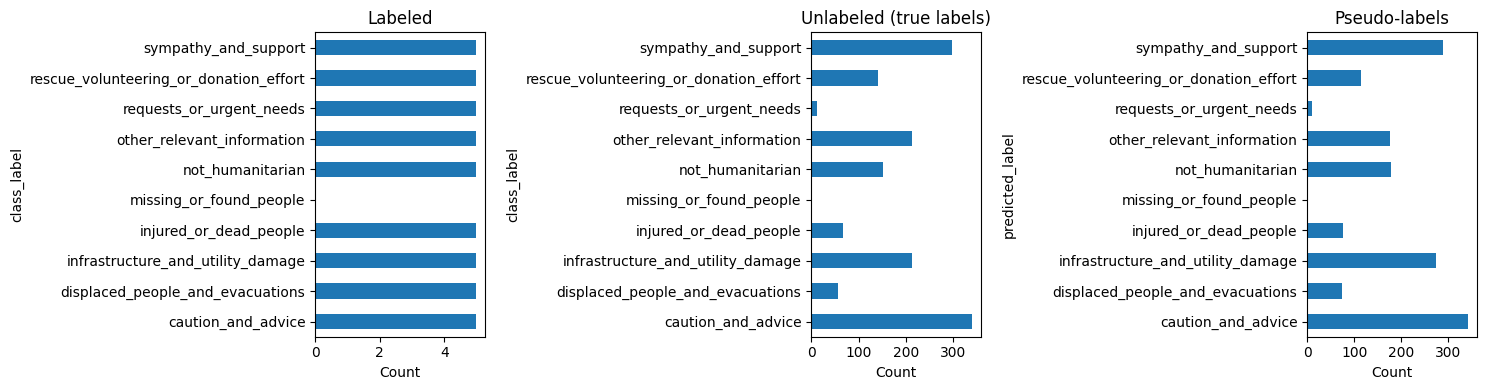


Pseudo-label accuracy: 71.8%
Mean pseudo-label confidence: 0.909


In [4]:
# Class distribution in each split
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

for ax, (name, df, col) in zip(axes, [
    ("Labeled", df_labeled, "class_label"),
    ("Unlabeled (true labels)", df_unlabeled, "class_label"),
    ("Pseudo-labels", df_pseudo, "predicted_label"),
]):
    counts = df[col].value_counts().reindex(CLASS_LABELS, fill_value=0)
    counts.plot.barh(ax=ax)
    ax.set_title(name)
    ax.set_xlabel("Count")

plt.tight_layout()
plt.show()

# Pseudo-label accuracy (comparing predicted_label to ground-truth class_label)
pseudo_acc = evaluate_pseudo_labels(
    df_pseudo["class_label"].tolist(),
    df_pseudo["predicted_label"].tolist(),
)
print(f"\nPseudo-label accuracy: {pseudo_acc:.1f}%")
print(f"Mean pseudo-label confidence: {df_pseudo['confidence'].mean():.3f}")

## 4. Data Preparation

Three key steps:

1. **Label encoding**: Map the 10 class names to integer IDs (0-9) using
   alphabetical ordering defined in `CLASS_LABELS`. Not all events contain
   samples from every class.
2. **Stratified split**: Split the labeled set into D_l1 and D_l2 with
   per-class stratification — for each class, shuffle and assign first half
   to D_l1, second half to D_l2.
3. **D_LG construction**: Join the unlabeled tweets with their GPT-4o
   pseudo-labels on `tweet_id` to form the pseudo-labeled training set.

In [4]:
# Detect event-specific classes from all data splits
event_classes = detect_event_classes(df_labeled, df_unlabeled, df_dev, df_test)
cfg.num_labels = len(event_classes)
print(f"Event classes ({cfg.num_labels}): {event_classes}")

# Build label encoder using only this event's classes
label2id, id2label = build_label_encoder(labels=event_classes)
print("\nLabel encoding:")
for label, idx in label2id.items():
    print(f"  {idx}: {label}")

# Split labeled set into D_l1 and D_l2
df_l1, df_l2 = split_labeled_set(df_labeled, seed=cfg.seed_set)
print(f"\nD_l1: {len(df_l1)} samples, D_l2: {len(df_l2)} samples")

# Build D_LG (join unlabeled with pseudo-labels)
df_dlg = build_d_lg(df_unlabeled, df_pseudo)
print(f"D_LG: {len(df_dlg)} samples")

# Encode pseudo-labels as integer IDs
pseudo_label_ids = np.array([label2id[lbl] for lbl in df_dlg["predicted_label"]])
num_dlg = len(df_dlg)
print(f"\nPseudo-label ID distribution: {np.bincount(pseudo_label_ids, minlength=cfg.num_labels)}")

Event classes (9): ['caution_and_advice', 'displaced_people_and_evacuations', 'infrastructure_and_utility_damage', 'injured_or_dead_people', 'not_humanitarian', 'other_relevant_information', 'requests_or_urgent_needs', 'rescue_volunteering_or_donation_effort', 'sympathy_and_support']

Label encoding:
  0: caution_and_advice
  1: displaced_people_and_evacuations
  2: infrastructure_and_utility_damage
  3: injured_or_dead_people
  4: not_humanitarian
  5: other_relevant_information
  6: requests_or_urgent_needs
  7: rescue_volunteering_or_donation_effort
  8: sympathy_and_support

D_l1: 27 samples, D_l2: 18 samples
D_LG: 1491 samples

Pseudo-label ID distribution: [334  71 269  71 171 174   8 109 284]


## 5. Tokenization and Dataset Creation

We tokenize all text using `BertTokenizer` with max length 128 and create
`TweetDataset` instances (PyTorch `Dataset` subclass) for each split.
Each dataset item returns `input_ids`, `attention_mask`, `labels`, and
`sample_idx` (used for per-sample weight lookup in Phase 2).

In [5]:
tokenizer = BertTokenizer.from_pretrained(cfg.model_name)

def encode_labels(series):
    """Map label names to integer IDs."""
    return [label2id[lbl] for lbl in series]

def make_dataset(texts, labels):
    """Create a TweetDataset from texts and integer labels."""
    return TweetDataset(
        texts=texts,
        labels=labels,
        tokenizer=tokenizer,
        max_length=cfg.max_seq_length,
    )

# Build datasets
ds_l1 = make_dataset(df_l1["tweet_text"].tolist(), encode_labels(df_l1["class_label"]))
ds_l2 = make_dataset(df_l2["tweet_text"].tolist(), encode_labels(df_l2["class_label"]))
ds_dlg = make_dataset(df_dlg["tweet_text"].tolist(), pseudo_label_ids.tolist())
ds_dev = make_dataset(df_dev["tweet_text"].tolist(), encode_labels(df_dev["class_label"]))
ds_test = make_dataset(df_test["tweet_text"].tolist(), encode_labels(df_test["class_label"]))

# Build dataloaders
loader_l1 = DataLoader(ds_l1, batch_size=cfg.batch_size, shuffle=True)
loader_l2 = DataLoader(ds_l2, batch_size=cfg.batch_size, shuffle=True)
loader_dlg_train = DataLoader(ds_dlg, batch_size=cfg.batch_size, shuffle=True)
loader_dlg_eval = DataLoader(ds_dlg, batch_size=cfg.batch_size, shuffle=False)
loader_dev = DataLoader(ds_dev, batch_size=cfg.batch_size, shuffle=False)
loader_test = DataLoader(ds_test, batch_size=cfg.batch_size, shuffle=False)

print(f"Datasets created:")
print(f"  D_l1:   {len(ds_l1):>5} samples, {len(loader_l1)} batches")
print(f"  D_l2:   {len(ds_l2):>5} samples, {len(loader_l2)} batches")
print(f"  D_LG:   {len(ds_dlg):>5} samples, {len(loader_dlg_train)} batches")
print(f"  Dev:    {len(ds_dev):>5} samples, {len(loader_dev)} batches")
print(f"  Test:   {len(ds_test):>5} samples, {len(loader_test)} batches")

Datasets created:
  D_l1:      27 samples, 1 batches
  D_l2:      18 samples, 1 batches
  D_LG:    1491 samples, 47 batches
  Dev:      224 samples, 7 batches
  Test:     435 samples, 14 batches


## 6. Helper: Collect Probabilities

The `collect_probs` function runs a model in eval mode over D_LG and extracts
`p(pseudo_label | x; theta)` — the model's softmax probability assigned to each
sample's pseudo-label. This is the core signal used by `WeightTracker` to compute
confidence and variability weights.

The function uses `sample_idx` from the dataset to correctly map batch outputs
back to their original positions (important when the dataloader doesn't shuffle).

In [6]:
def collect_probs(model, loader, pseudo_label_ids):
    """Collect p(pseudo_label | x; theta) for each sample in D_LG.

    Args:
        model: The model to evaluate.
        loader: Non-shuffled DataLoader over D_LG.
        pseudo_label_ids: Array of pseudo-label class indices per sample.

    Returns:
        Array of shape (num_samples,) with per-sample probabilities.
    """
    model.eval()
    all_probs = []
    all_indices = []

    with torch.no_grad():
        for batch in loader:
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            sample_idx = batch["sample_idx"].numpy()

            probs = model.predict_proba(input_ids, attention_mask).cpu().numpy()
            all_probs.append(probs)
            all_indices.append(sample_idx)

    all_probs = np.concatenate(all_probs, axis=0)  # (N, num_classes)
    all_indices = np.concatenate(all_indices, axis=0)

    # Extract p(pseudo_label) for each sample
    result = np.zeros(len(pseudo_label_ids))
    for i, idx in enumerate(all_indices):
        result[idx] = all_probs[i, pseudo_label_ids[idx]]

    return result

print("collect_probs helper defined.")

collect_probs helper defined.


## 7. Phase 1: Weight Generation

In this phase, we train two **fresh** BERT models on separate halves of the
labeled set:
- **Model 1** trains on D_l1
- **Model 2** trains on D_l2

After each epoch, both models' softmax probabilities over D_LG are recorded by
`WeightTracker`. After all epochs, we compute:
- **Confidence** = mean of p(pseudo_label | x; theta) across epochs
- **Variability** = std of the same
- **Lambda-optimistic** (lambda1) = confidence + variability
- **Lambda-conservative** (lambda2) = max(confidence - variability, 0)

These lambda weights tell Phase 2 how much to trust each pseudo-labeled sample.

In [7]:
print("=== Phase 1: Weight Generation ===")
model1 = create_fresh_model(cfg).to(device)
model2 = create_fresh_model(cfg).to(device)
opt1 = Adam(model1.parameters(), lr=cfg.lr)
opt2 = Adam(model2.parameters(), lr=cfg.lr)

tracker1 = WeightTracker(num_dlg)
tracker2 = WeightTracker(num_dlg)

# Track mean probs per epoch for visualization
phase1_mean_probs1 = []
phase1_mean_probs2 = []

for epoch in range(cfg.weight_gen_epochs):
    # Train model1 on D_l1
    model1.train()
    for batch in loader_l1:
        opt1.zero_grad()
        logits = model1(
            batch["input_ids"].to(device),
            batch["attention_mask"].to(device),
        )
        loss = F.cross_entropy(logits, batch["labels"].to(device))
        loss.backward()
        opt1.step()

    # Train model2 on D_l2
    model2.train()
    for batch in loader_l2:
        opt2.zero_grad()
        logits = model2(
            batch["input_ids"].to(device),
            batch["attention_mask"].to(device),
        )
        loss = F.cross_entropy(logits, batch["labels"].to(device))
        loss.backward()
        opt2.step()

    # Record probabilities over D_LG
    probs1 = collect_probs(model1, loader_dlg_eval, pseudo_label_ids)
    probs2 = collect_probs(model2, loader_dlg_eval, pseudo_label_ids)
    tracker1.record_epoch(probs1)
    tracker2.record_epoch(probs2)

    phase1_mean_probs1.append(probs1.mean())
    phase1_mean_probs2.append(probs2.mean())

    print(
        f"  Epoch {epoch+1}/{cfg.weight_gen_epochs}: "
        f"mean_prob1={probs1.mean():.4f}, mean_prob2={probs2.mean():.4f}"
    )

# Compute lambda weights
lambda1 = tracker1.compute_lambda_optimistic()
lambda2 = tracker2.compute_lambda_conservative()

print(f"\nPhase 1 complete.")
print(f"  Lambda1 (optimistic):    mean={lambda1.mean():.4f}, range=[{lambda1.min():.4f}, {lambda1.max():.4f}]")
print(f"  Lambda2 (conservative):  mean={lambda2.mean():.4f}, range=[{lambda2.min():.4f}, {lambda2.max():.4f}]")

=== Phase 1: Weight Generation ===


Loading weights: 100%|███████████████| 199/199 [00:00<00:00, 1080.55it/s, Materializing param=bert.pooler.dense.weight]


  Epoch 1/7: mean_prob1=0.1232, mean_prob2=0.1028
  Epoch 2/7: mean_prob1=0.1204, mean_prob2=0.1054
  Epoch 3/7: mean_prob1=0.1154, mean_prob2=0.1083
  Epoch 4/7: mean_prob1=0.1165, mean_prob2=0.1118
  Epoch 5/7: mean_prob1=0.1182, mean_prob2=0.1166
  Epoch 6/7: mean_prob1=0.1185, mean_prob2=0.1204
  Epoch 7/7: mean_prob1=0.1194, mean_prob2=0.1231

Phase 1 complete.
  Lambda1 (optimistic):    mean=0.1296, range=[0.0681, 0.2088]
  Lambda2 (conservative):  mean=0.0969, range=[0.0273, 0.2124]


### Phase 1 Results Analysis

Let's visualize how the models' confidence in the pseudo-labels evolved during
Phase 1, and examine the resulting lambda weight distributions.

- **Probability evolution**: How mean p(pseudo_label) changes across epochs
- **Lambda distributions**: Histogram of optimistic vs conservative weights
- **Confidence vs Variability**: Scatter plot showing the relationship

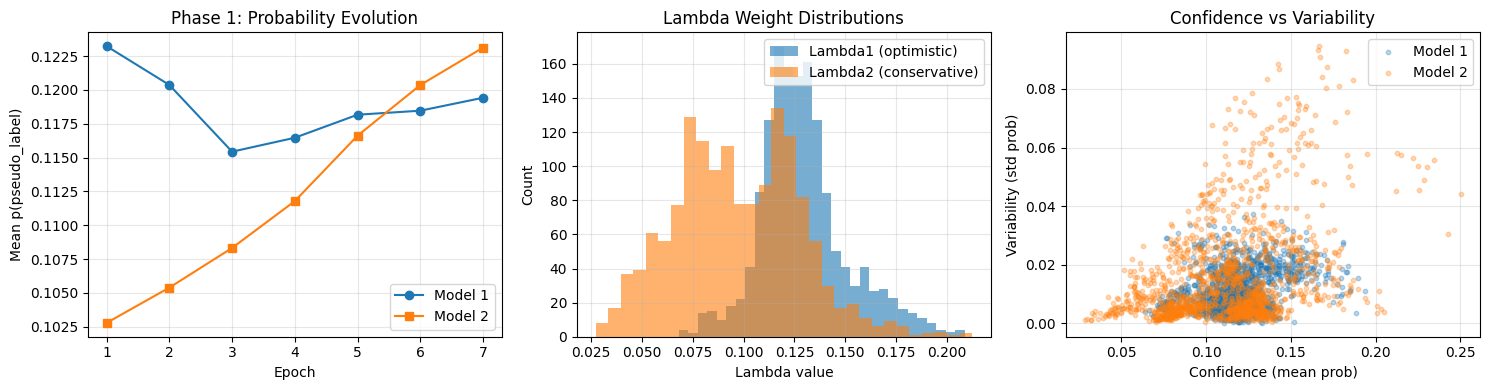

In [8]:
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

# 1. Probability evolution across epochs
ax = axes[0]
epochs_range = range(1, cfg.weight_gen_epochs + 1)
ax.plot(epochs_range, phase1_mean_probs1, "o-", label="Model 1")
ax.plot(epochs_range, phase1_mean_probs2, "s-", label="Model 2")
ax.set_xlabel("Epoch")
ax.set_ylabel("Mean p(pseudo_label)")
ax.set_title("Phase 1: Probability Evolution")
ax.legend()
ax.grid(True, alpha=0.3)

# 2. Lambda distributions
ax = axes[1]
ax.hist(lambda1, bins=30, alpha=0.6, label="Lambda1 (optimistic)", color="tab:blue")
ax.hist(lambda2, bins=30, alpha=0.6, label="Lambda2 (conservative)", color="tab:orange")
ax.set_xlabel("Lambda value")
ax.set_ylabel("Count")
ax.set_title("Lambda Weight Distributions")
ax.legend()
ax.grid(True, alpha=0.3)

# 3. Confidence vs Variability scatter
ax = axes[2]
conf1 = tracker1.compute_confidence()
var1 = tracker1.compute_variability()
conf2 = tracker2.compute_confidence()
var2 = tracker2.compute_variability()
ax.scatter(conf1, var1, alpha=0.3, s=10, label="Model 1")
ax.scatter(conf2, var2, alpha=0.3, s=10, label="Model 2")
ax.set_xlabel("Confidence (mean prob)")
ax.set_ylabel("Variability (std prob)")
ax.set_title("Confidence vs Variability")
ax.legend()
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 8. Phase 2: Co-Training

Two **fresh** BERT models train on D_LG using **weighted cross-entropy**:
- **Model 1's** loss is weighted by **lambda2** (conservative weights from Model 2's tracker)
- **Model 2's** loss is weighted by **lambda1** (optimistic weights from Model 1's tracker)

This cross-weighting creates a co-training effect: each model trusts the other's
assessment of pseudo-label quality.

The Phase 2 trackers are **seeded** with the full Phase 1 probability history
(all 7 epochs), so that initial lambda weights retain the confidence/variability
split computed during weight generation. This means lambda1 != lambda2 from the
very first co-training epoch, preserving the asymmetric weighting that is central
to the co-training mechanism (per Algorithm 1 in the paper). As co-training
progresses, new probabilities are recorded and lambdas continue to evolve.

In [ ]:
print("=== Phase 2: Co-Training ===")
model1 = create_fresh_model(cfg).to(device)
model2 = create_fresh_model(cfg).to(device)
opt1 = Adam(model1.parameters(), lr=cfg.lr)
opt2 = Adam(model2.parameters(), lr=cfg.lr)

# Seed Phase 2 trackers with FULL Phase 1 probability history
# so initial lambdas retain the confidence/variability split
cotrain_tracker1 = WeightTracker.seed_from_tracker(tracker1)
cotrain_tracker2 = WeightTracker.seed_from_tracker(tracker2)

# lambda1, lambda2 already computed from full Phase 1 history above

# Track metrics for visualization
phase2_losses1 = []
phase2_losses2 = []
phase2_dev_f1s = []

for epoch in range(cfg.cotrain_epochs):
    model1.train()
    model2.train()
    epoch_loss1 = 0.0
    epoch_loss2 = 0.0
    n_batches = 0

    for batch in loader_dlg_train:
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        labels = batch["labels"].to(device)
        sample_idx = batch["sample_idx"].numpy()

        # Get per-sample weights
        w2 = torch.tensor(
            lambda2[sample_idx], dtype=torch.float32, device=device
        )
        w1 = torch.tensor(
            lambda1[sample_idx], dtype=torch.float32, device=device
        )

        # Model 1 loss (uses theta2's weights = lambda2)
        logits1 = model1(input_ids, attention_mask)
        per_sample_loss1 = F.cross_entropy(logits1, labels, reduction="none")
        loss1 = (w2 * per_sample_loss1).mean()

        opt1.zero_grad()
        loss1.backward()
        opt1.step()

        # Model 2 loss (uses theta1's weights = lambda1)
        logits2 = model2(input_ids, attention_mask)
        per_sample_loss2 = F.cross_entropy(logits2, labels, reduction="none")
        loss2 = (w1 * per_sample_loss2).mean()

        opt2.zero_grad()
        loss2.backward()
        opt2.step()

        epoch_loss1 += loss1.item()
        epoch_loss2 += loss2.item()
        n_batches += 1

    # Update probabilities and recompute lambdas
    probs1 = collect_probs(model1, loader_dlg_eval, pseudo_label_ids)
    probs2 = collect_probs(model2, loader_dlg_eval, pseudo_label_ids)
    cotrain_tracker1.record_epoch(probs1)
    cotrain_tracker2.record_epoch(probs2)
    lambda1 = cotrain_tracker1.compute_lambda_optimistic()
    lambda2 = cotrain_tracker2.compute_lambda_conservative()

    # Evaluate ensemble on dev
    dev_preds, dev_labels, _ = ensemble_predict(model1, model2, loader_dev, device)
    dev_metrics = compute_metrics(dev_labels, dev_preds)

    avg_loss1 = epoch_loss1 / n_batches
    avg_loss2 = epoch_loss2 / n_batches
    phase2_losses1.append(avg_loss1)
    phase2_losses2.append(avg_loss2)
    phase2_dev_f1s.append(dev_metrics["macro_f1"])

    print(
        f"  Epoch {epoch+1}/{cfg.cotrain_epochs}: "
        f"loss1={avg_loss1:.4f}, loss2={avg_loss2:.4f}, "
        f"dev_macro_f1={dev_metrics['macro_f1']:.4f}, dev_err={dev_metrics['error_rate']:.2f}%"
    )

print(f"\nPhase 2 complete. Best dev F1: {max(phase2_dev_f1s):.4f}")

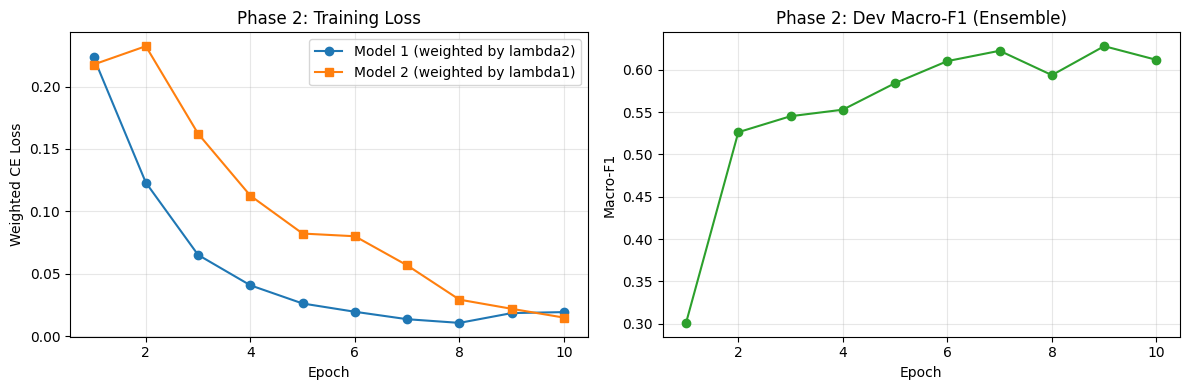

In [10]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

epochs_range = range(1, cfg.cotrain_epochs + 1)

# 1. Loss curves
ax = axes[0]
ax.plot(epochs_range, phase2_losses1, "o-", label="Model 1 (weighted by lambda2)")
ax.plot(epochs_range, phase2_losses2, "s-", label="Model 2 (weighted by lambda1)")
ax.set_xlabel("Epoch")
ax.set_ylabel("Weighted CE Loss")
ax.set_title("Phase 2: Training Loss")
ax.legend()
ax.grid(True, alpha=0.3)

# 2. Dev macro-F1
ax = axes[1]
ax.plot(epochs_range, phase2_dev_f1s, "o-", color="tab:green")
ax.set_xlabel("Epoch")
ax.set_ylabel("Macro-F1")
ax.set_title("Phase 2: Dev Macro-F1 (Ensemble)")
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 9. Phase 3: Fine-Tuning

Both co-trained models are fine-tuned on their respective labeled splits:
- **Model 1** fine-tunes on D_l1
- **Model 2** fine-tunes on D_l2

We use **early stopping** on dev macro-F1 with patience=5. The ensemble
(averaged softmax) is evaluated on the dev set each epoch. Training stops
when both models' early stopping counters exceed patience.

After training, we restore both models to their best checkpoints.

In [ ]:
print("=== Phase 3: Fine-Tuning ===")
es1 = EarlyStopping(patience=cfg.finetune_patience)
es2 = EarlyStopping(patience=cfg.finetune_patience)

phase3_dev_f1s = []

for epoch in range(cfg.finetune_max_epochs):
    # Fine-tune model1 on D_l1
    model1.train()
    for batch in loader_l1:
        opt1.zero_grad()
        logits = model1(
            batch["input_ids"].to(device),
            batch["attention_mask"].to(device),
        )
        loss = F.cross_entropy(logits, batch["labels"].to(device))
        loss.backward()
        opt1.step()

    # Fine-tune model2 on D_l2
    model2.train()
    for batch in loader_l2:
        opt2.zero_grad()
        logits = model2(
            batch["input_ids"].to(device),
            batch["attention_mask"].to(device),
        )
        loss = F.cross_entropy(logits, batch["labels"].to(device))
        loss.backward()
        opt2.step()

    # Evaluate ensemble on dev
    dev_preds, dev_labels, _ = ensemble_predict(model1, model2, loader_dev, device)
    dev_metrics = compute_metrics(dev_labels, dev_preds)
    dev_f1 = dev_metrics["macro_f1"]

    stop1 = es1.step(dev_f1, model1)
    stop2 = es2.step(dev_f1, model2)
    phase3_dev_f1s.append(dev_f1)

    print(
        f"  Epoch {epoch+1}: dev_macro_f1={dev_f1:.4f}, "
        f"dev_err={dev_metrics['error_rate']:.2f}%, "
        f"es_counter1={es1.counter}, es_counter2={es2.counter}"
    )

    if stop1 and stop2:
        print(f"\nEarly stopping at epoch {epoch+1}")
        break

# Restore best models
es1.restore_best(model1)
es2.restore_best(model2)
print(f"\nPhase 3 complete. Best dev F1: {es1.best_score:.4f}")

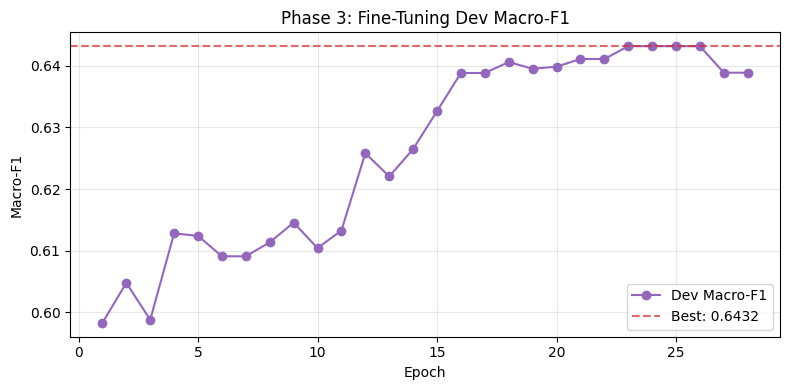

In [13]:
fig, ax = plt.subplots(figsize=(8, 4))

epochs_range = range(1, len(phase3_dev_f1s) + 1)
ax.plot(epochs_range, phase3_dev_f1s, "o-", color="tab:purple", label="Dev Macro-F1")
ax.axhline(y=es1.best_score, color="tab:red", linestyle="--", alpha=0.7, label=f"Best: {es1.best_score:.4f}")
ax.set_xlabel("Epoch")
ax.set_ylabel("Macro-F1")
ax.set_title("Phase 3: Fine-Tuning Dev Macro-F1")
ax.legend()
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 10. Final Evaluation

We evaluate the best ensemble (restored from early stopping checkpoints) on both
the **test set** and **dev set**. The ensemble averages the softmax probabilities
from both models and takes the argmax as the final prediction.

Metrics reported:
- **Error rate** (%): Percentage of misclassified samples
- **Macro-F1**: Unweighted average F1 across all classes
- **Per-class F1**: F1 score for each individual class

In [ ]:
print("=== Final Evaluation ===")

test_preds, test_labels, test_probs = ensemble_predict(model1, model2, loader_test, device)
test_metrics = compute_metrics(test_labels, test_preds)
test_ece = compute_ece(test_labels, test_probs)

dev_preds, dev_labels, dev_probs = ensemble_predict(model1, model2, loader_dev, device)
dev_metrics = compute_metrics(dev_labels, dev_preds)
dev_ece = compute_ece(dev_labels, dev_probs)

print(f"\nTest Results:")
print(f"  Error Rate: {test_metrics['error_rate']:.2f}%")
print(f"  Macro-F1:   {test_metrics['macro_f1']:.4f}")
print(f"  ECE:        {test_ece:.4f}")
print(f"\nDev Results:")
print(f"  Error Rate: {dev_metrics['error_rate']:.2f}%")
print(f"  Macro-F1:   {dev_metrics['macro_f1']:.4f}")
print(f"  ECE:        {dev_ece:.4f}")

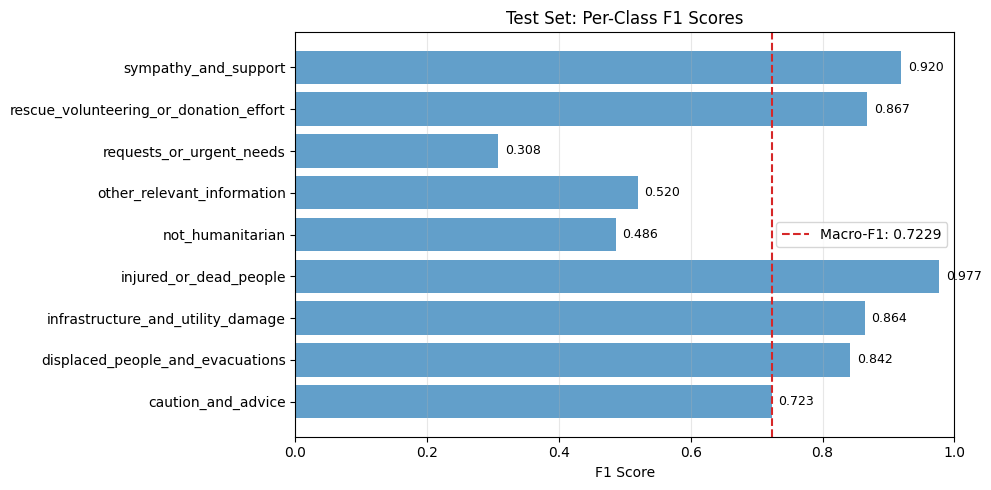

In [15]:
# Per-class F1 breakdown (using event-specific classes)
fig, ax = plt.subplots(figsize=(10, 5))

per_class_f1 = test_metrics["per_class_f1"]
# Pad if fewer per-class scores than event classes
while len(per_class_f1) < len(event_classes):
    per_class_f1.append(0.0)

bars = ax.barh(event_classes, per_class_f1[:len(event_classes)], color="tab:blue", alpha=0.7)
ax.axvline(x=test_metrics["macro_f1"], color="tab:red", linestyle="--",
           label=f"Macro-F1: {test_metrics['macro_f1']:.4f}")
ax.set_xlabel("F1 Score")
ax.set_title("Test Set: Per-Class F1 Scores")
ax.set_xlim(0, 1.0)
ax.legend()
ax.grid(True, alpha=0.3, axis="x")

# Add value labels on bars
for bar, f1 in zip(bars, per_class_f1[:len(event_classes)]):
    ax.text(bar.get_width() + 0.01, bar.get_y() + bar.get_height() / 2,
            f"{f1:.3f}", va="center", fontsize=9)

plt.tight_layout()
plt.show()

In [ ]:
# Save results to JSON (matches trainer.py output format)
results = {
    "event": cfg.event,
    "budget": cfg.budget,
    "seed_set": cfg.seed_set,
    "test_error_rate": test_metrics["error_rate"],
    "test_macro_f1": test_metrics["macro_f1"],
    "test_ece": test_ece,
    "test_per_class_f1": test_metrics["per_class_f1"],
    "dev_error_rate": dev_metrics["error_rate"],
    "dev_macro_f1": dev_metrics["macro_f1"],
    "dev_ece": dev_ece,
    "lambda1_mean": float(lambda1.mean()),
    "lambda1_std": float(lambda1.std()),
    "lambda2_mean": float(lambda2.mean()),
    "lambda2_std": float(lambda2.std()),
}

output_path = Path(cfg.output_dir) / "metrics.json"
output_path.parent.mkdir(parents=True, exist_ok=True)
with open(output_path, "w") as f:
    json.dump(results, f, indent=2)

print(f"Results saved to {output_path}")
print(f"\nFull results:")
print(json.dumps(results, indent=2))

## 11. Full Experiment Grid: All Budgets x Seed Sets

The single experiment above used **budget=5, seed_set=1**. To get statistically
robust results, we run all **12 combinations** (4 budgets x 3 seed sets) and
aggregate across seed sets per budget to compute **mean +/- std**.

This uses the `run_all_experiments` batch runner, which:
- Iterates over budgets [5, 10, 25, 50] x seed sets [1, 2, 3]
- **Skips** experiments whose `metrics.json` already exists (e.g. the one we just ran)
- Isolates failures so one bad run doesn't abort the batch
- Frees GPU memory between experiments

In [ ]:
from lg_cotrain.run_all import BUDGETS, SEED_SETS, run_all_experiments, format_summary_table

EVENT = "kaikoura_earthquake_2016"

all_results = run_all_experiments(
    EVENT,
    data_root=str(repo_root / "data"),
    results_root=str(repo_root / "results"),
)

In [ ]:
print(format_summary_table(all_results, EVENT))

### Results by Budget

We visualize how test macro-F1 and error rate vary with the labeled budget.
Each dot represents one seed set; the bar shows the mean across the 3 seeds.

In [ ]:
import statistics

# Organize results by budget
results_by_budget = {b: [] for b in BUDGETS}
for r in all_results:
    if r is not None:
        results_by_budget[r["budget"]].append(r)

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# --- Macro-F1 by budget ---
ax = axes[0]
means, stds = [], []
for b in BUDGETS:
    f1s = [r["test_macro_f1"] for r in results_by_budget[b]]
    means.append(statistics.mean(f1s) if f1s else 0)
    stds.append(statistics.stdev(f1s) if len(f1s) >= 2 else 0)
    # Plot individual seeds as dots
    for r in results_by_budget[b]:
        ax.scatter(b, r["test_macro_f1"], color="tab:blue", alpha=0.5, zorder=3)

ax.bar(BUDGETS, means, width=[2, 4, 8, 15], alpha=0.3, color="tab:blue")
ax.errorbar(BUDGETS, means, yerr=stds, fmt="none", ecolor="black", capsize=5)
ax.set_xlabel("Budget (labeled samples per class)")
ax.set_ylabel("Test Macro-F1")
ax.set_title("Macro-F1 by Budget")
ax.set_xticks(BUDGETS)
ax.grid(True, alpha=0.3, axis="y")

# --- Error rate by budget ---
ax = axes[1]
means, stds = [], []
for b in BUDGETS:
    errs = [r["test_error_rate"] for r in results_by_budget[b]]
    means.append(statistics.mean(errs) if errs else 0)
    stds.append(statistics.stdev(errs) if len(errs) >= 2 else 0)
    for r in results_by_budget[b]:
        ax.scatter(b, r["test_error_rate"], color="tab:orange", alpha=0.5, zorder=3)

ax.bar(BUDGETS, means, width=[2, 4, 8, 15], alpha=0.3, color="tab:orange")
ax.errorbar(BUDGETS, means, yerr=stds, fmt="none", ecolor="black", capsize=5)
ax.set_xlabel("Budget (labeled samples per class)")
ax.set_ylabel("Test Error Rate (%)")
ax.set_title("Error Rate by Budget")
ax.set_xticks(BUDGETS)
ax.grid(True, alpha=0.3, axis="y")

plt.tight_layout()
plt.show()

# Print per-budget summary
for b in BUDGETS:
    f1s = [r["test_macro_f1"] for r in results_by_budget[b]]
    errs = [r["test_error_rate"] for r in results_by_budget[b]]
    if len(f1s) >= 2:
        print(
            f"Budget {b:>2}: F1 = {statistics.mean(f1s):.4f} +/- {statistics.stdev(f1s):.4f}, "
            f"Error = {statistics.mean(errs):.2f}% +/- {statistics.stdev(errs):.2f}%"
        )
    elif f1s:
        print(f"Budget {b:>2}: F1 = {f1s[0]:.4f}, Error = {errs[0]:.2f}% (1 seed)")

## Summary

This notebook ran the full LG-CoTrain pipeline on the **kaikoura_earthquake_2016** dataset.

### Single experiment walkthrough (Sections 1-10)
Detailed step-by-step execution of **budget=5, seed_set=1**:
1. **Phase 1** trained two BERT models on labeled splits and recorded confidence/variability
   weights over the pseudo-labeled set across 7 epochs.
2. **Phase 2** used those weights for co-training on D_LG (10 epochs), where each model's
   loss was weighted by the other model's lambda weights.
3. **Phase 3** fine-tuned both models on their labeled splits with early stopping.

### Full experiment grid (Section 11)
Ran all **12 combinations** (4 budgets x 3 seed sets) to produce robust per-budget
estimates with mean +/- std across seed sets.

### CLI equivalent
```bash
# Single experiment
python -m lg_cotrain.run_experiment --event kaikoura_earthquake_2016 --budget 5 --seed-set 1

# All 12 experiments
python -m lg_cotrain.run_all --event kaikoura_earthquake_2016
```